In [1]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
print (tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [3]:
df = pd.read_csv("Hurricanes2.csv")
df =df.dropna()

In [4]:
print (df)

                 time    lon   lat         slp     airsfc    pr_wtr  \
158        1980-06-07    0.0  90.0  1007.98004  267.14000  6.160004   
159        1980-06-08    0.0  90.0  1008.22003  269.63000  7.720001   
160        1980-06-09    0.0  90.0  1010.36005  265.36000  9.940002   
161        1980-06-10    0.0  90.0  1010.45000  272.27002  9.220001   
162        1980-06-11    0.0  90.0  1009.39000  270.80000  4.820007   
...               ...    ...   ...         ...        ...       ...   
165101467  2022-12-27  357.5 -90.0   977.55005  251.40000  1.100006   
165101468  2022-12-28  357.5 -90.0   981.80005  249.14000  0.869995   
165101469  2022-12-29  357.5 -90.0   983.10004  249.09000  0.850006   
165101470  2022-12-30  357.5 -90.0   985.34000  246.56000  0.809998   
165101471  2022-12-31  357.5 -90.0   984.73004  248.43000  0.820007   

             rhumsfc       trpp      uwnd      vwnd       trpt  Hurricane  
158        74.550000  351.71106  4.429993  1.759994  229.15000         

In [5]:
neg, pos = np.bincount(df['Hurricane'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.4f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 163440576
    Positive: 1525 (0.0009% of total)



In [6]:
month = []
year = []
day = []
for i in df["time"].index:
    month.append(float(str(df.at[i, "time"])[5:7]))
    year.append(float(str(df.at[i, "time"])[0:4]))
    #day.append(float(str(df.at[i, "time"])[8:]))

In [7]:
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Not Hurricane (True Negatives): ', cm[0][0])
    print('False Hurricane Predcition (False Positives): ', cm[0][1])
    print('Missed Hurricane (False Negatives): ', cm[1][0])
    print('Hurricanes Found (True Positives): ', cm[1][1])
    print('Total Hurricanes: ', np.sum(cm[1]))


In [8]:
cleaned_df = df.copy()
#cleaned_df.pop("lon")
#leaned_df.pop("lat")
# You don't want the `Time` column.

cleaned_df.pop('time')
cleaned_df["month"] = month
cleaned_df["year"] = year
#cleaned_df["day"] = day
cleaned_df.insert(0, "year", cleaned_df.pop("year"))
cleaned_df.insert(0, "month", cleaned_df.pop("month"))


In [9]:
print (cleaned_df)

           month    year    lon   lat         slp     airsfc    pr_wtr  \
158          6.0  1980.0    0.0  90.0  1007.98004  267.14000  6.160004   
159          6.0  1980.0    0.0  90.0  1008.22003  269.63000  7.720001   
160          6.0  1980.0    0.0  90.0  1010.36005  265.36000  9.940002   
161          6.0  1980.0    0.0  90.0  1010.45000  272.27002  9.220001   
162          6.0  1980.0    0.0  90.0  1009.39000  270.80000  4.820007   
...          ...     ...    ...   ...         ...        ...       ...   
165101467   12.0  2022.0  357.5 -90.0   977.55005  251.40000  1.100006   
165101468   12.0  2022.0  357.5 -90.0   981.80005  249.14000  0.869995   
165101469   12.0  2022.0  357.5 -90.0   983.10004  249.09000  0.850006   
165101470   12.0  2022.0  357.5 -90.0   985.34000  246.56000  0.809998   
165101471   12.0  2022.0  357.5 -90.0   984.73004  248.43000  0.820007   

             rhumsfc       trpp      uwnd      vwnd       trpt  Hurricane  
158        74.550000  351.71106  4.

In [10]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Hurricane'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Hurricane'))
test_labels = np.array(test_df.pop('Hurricane'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [11]:
print(f'Average hurricane probability in training set:   {train_labels.mean():.10f}')
print(f'Average hurricane probability in validation set: {val_labels.mean():.10f}')
print(f'Average hurricane probability in test set:       {test_labels.mean():.10f}')


Average hurricane probability in training set:   0.0000093593
Average hurricane probability in validation set: 0.0000092159
Average hurricane probability in test set:       0.0000093306


In [12]:
month = []
year = []
day = []
df = pd.DataFrame()

In [18]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
      #keras.metrics.F1Score(name = 'f1_score')
]


In [19]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        keras.layers.Input(shape=(train_features.shape[-1],)),  # Adjust num_features based on your actual feature dimensions
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.6),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.6),
        keras.layers.Dense(16, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
        ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [20]:
initial_bias = np.log([pos/neg])
initial_bias

array([-11.58220101])

In [21]:
EPOCHS = 100
BATCH_SIZE = 16384
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)



In [22]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]


In [23]:
BUFFER_SIZE = 104601968

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


In [24]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)


In [25]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())


0.5006103515625


In [26]:
resampled_steps_per_epoch = np.ceil(neg/BATCH_SIZE)
resampled_steps_per_epoch

9976.0

In [27]:
resampled_model = make_model(output_bias=initial_bias)

output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch= 60,
    epochs=3*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))



Epoch 1/300
60/60 [==============================] - 297s 1s/step - loss: 0.6166 - cross entropy: 0.6166 - Brier score: 0.2008 - tp: 361399.0000 - fp: 165312.0000 - tn: 326037.0000 - fn: 130292.0000 - accuracy: 0.6993 - precision: 0.6861 - recall: 0.7350 - auc: 0.7614 - prc: 0.6900 - val_loss: 1.4185 - val_cross entropy: 1.4185 - val_Brier score: 0.3946 - val_tp: 241.0000 - val_fp: 13418651.0000 - val_tn: 12731600.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4869 - val_precision: 1.7960e-05 - val_recall: 1.0000 - val_auc: 0.9168 - val_prc: 5.2794e-05
Epoch 2/300
60/60 [==============================] - 43s 721ms/step - loss: 0.3737 - cross entropy: 0.3737 - Brier score: 0.1145 - tp: 436736.0000 - fp: 95527.0000 - tn: 395209.0000 - fn: 55568.0000 - accuracy: 0.8463 - precision: 0.8205 - recall: 0.8871 - auc: 0.9110 - prc: 0.8765 - val_loss: 0.0057 - val_cross entropy: 0.0057 - val_Brier score: 9.1397e-05 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 26150316.0000 - val_fn: 241.0000

Epoch 16/300
60/60 [==============================] - 37s 634ms/step - loss: 0.1254 - cross entropy: 0.1254 - Brier score: 0.0315 - tp: 480804.0000 - fp: 26057.0000 - tn: 465429.0000 - fn: 10750.0000 - accuracy: 0.9626 - precision: 0.9486 - recall: 0.9781 - auc: 0.9863 - prc: 0.9796 - val_loss: 0.2487 - val_cross entropy: 0.2487 - val_Brier score: 0.0733 - val_tp: 241.0000 - val_fp: 2451764.0000 - val_tn: 23698468.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9062 - val_precision: 9.8287e-05 - val_recall: 1.0000 - val_auc: 0.9914 - val_prc: 8.5835e-04
Epoch 17/300
60/60 [==============================] - 39s 655ms/step - loss: 0.1232 - cross entropy: 0.1232 - Brier score: 0.0310 - tp: 480881.0000 - fp: 25590.0000 - tn: 465856.0000 - fn: 10713.0000 - accuracy: 0.9631 - precision: 0.9495 - recall: 0.9782 - auc: 0.9866 - prc: 0.9800 - val_loss: 0.2694 - val_cross entropy: 0.2694 - val_Brier score: 0.0765 - val_tp: 241.0000 - val_fp: 2461019.0000 - val_tn: 23689218.0000 - val_fn: 0.0000e+00 

Epoch 31/300
60/60 [==============================] - 34s 569ms/step - loss: 0.1062 - cross entropy: 0.1062 - Brier score: 0.0267 - tp: 482985.0000 - fp: 23868.0000 - tn: 468137.0000 - fn: 8050.0000 - accuracy: 0.9675 - precision: 0.9529 - recall: 0.9836 - auc: 0.9892 - prc: 0.9838 - val_loss: 0.0589 - val_cross entropy: 0.0589 - val_Brier score: 0.0182 - val_tp: 234.0000 - val_fp: 660309.0000 - val_tn: 25489946.0000 - val_fn: 7.0000 - val_accuracy: 0.9747 - val_precision: 3.5425e-04 - val_recall: 0.9710 - val_auc: 0.9943 - val_prc: 0.0011
Epoch 31: early stopping


In [24]:
resampled_history

In [23]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
valid_predictions_resampled = resampled_model.predict(val_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)


3991/3991 [==============================] - 11s 3ms/step


Not Hurricane (True Negatives):  31947144
False Hurricane Predcition (False Positives):  740655
Missed Hurricane (False Negatives):  16
Hurricanes Found (True Positives):  301
Total Hurricanes:  317


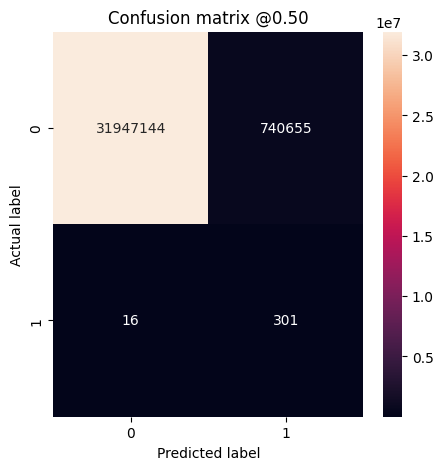

In [33]:
plot_cm(test_labels, test_predictions_resampled)

Not Hurricane (True Negatives):  102233793
False Hurricane Predcition (False Positives):  2367195
Missed Hurricane (False Negatives):  46
Hurricanes Found (True Positives):  934
Total Hurricanes:  980


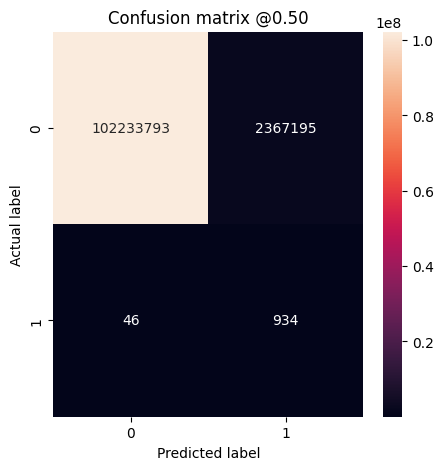

In [34]:
plot_cm(train_labels, train_predictions_resampled)

Not Hurricane (True Negatives):  25558381
False Hurricane Predcition (False Positives):  591883
Missed Hurricane (False Negatives):  4
Hurricanes Found (True Positives):  224
Total Hurricanes:  228


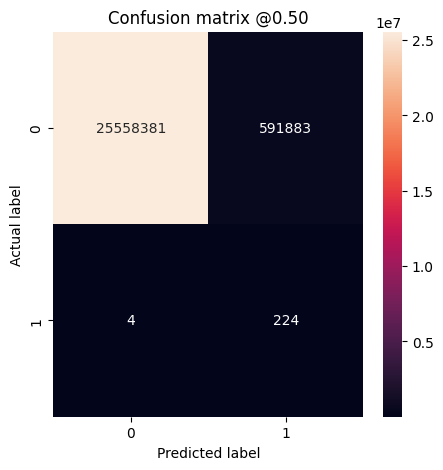

In [35]:
plot_cm(val_labels, valid_predictions_resampled)

In [ ]:
newdf = cleaned_df.copy()
full = np.array(newdf)
newdfl = = np.array(newdf.pop('Hurricane'))
plot_cm(newdf1, valid_predictions_resampled)

In [31]:
resampled_model.save('LesserSampledHierarchalFullData6.keras')